In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from fuzzywuzzy import process
import time
from uszipcode import SearchEngine
search = SearchEngine()

import utils as u
import init
init.run()
from config.GLOBAL import *

C:\Users\steff\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
def get_grayscale(N, darkest=0, brightest=238, darkling=True):
    print(N)
    darkest /= 255
    brightest /= 255
    grayscale = [(darkest, darkest, darkest)]
    for i in range(1,N):
        gray = darkest + i*(brightest-darkest)/(N-1)
        grayscale += [(gray,gray,gray)]
    if darkling:
        grayscale = grayscale[::-1]
    return grayscale

In [100]:
df = pd.read_csv("data/data_2011_to_2022_R.csv")
df = df.convert_dtypes()
df["time"] = pd.to_datetime(df["time"]).dt.date
df["date"] = pd.to_datetime(df["date"]).dt.date

df = df.rename(columns={"Unnamed: 0" : "tract-time"})

df = df.set_index(["time", "census_tract_2010"])
df.index.dtypes[1] = "int64"
df = df.replace(0.01, 0)
df

,,tract-time,county,zip_code,n_ev,n_bev,n_phev,m_ev,m_bev,m_phev,n_veh,...,p_bachelor,p_single_family_unit,date,tract_date,index,index_p,p_ev_log_odds_res,p_ev_log_odds_predict,p_ev_predict,p_ev_res
time,census_tract_2010,,,,,,,,,,,,,,,,,,,,,
2011-01-31,53001950100,53001950100-2011-01-31,Adams,99169,0.0,0.0,0.0,7,6,1,2066,...,0.146269,0.813604,2011-01-31,53001950100-2011-01-31,1,1,-1.891626,-14.130161,0.000001,-0.000004
2011-02-28,53001950100,53001950100-2011-02-28,Adams,99169,0.0,0.0,0.0,7,6,1,2042,...,0.146269,0.813604,2011-02-28,53001950100-2011-02-28,1438,2,-1.857698,-14.084548,0.000001,-0.000004
2011-03-31,53001950100,53001950100-2011-03-31,Adams,99169,0.0,0.0,0.0,7,6,1,2110,...,0.146269,0.813604,2011-03-31,53001950100-2011-03-31,2875,3,-1.82861,-14.088219,0.000001,-0.000004
2011-04-30,53001950100,53001950100-2011-04-30,Adams,99169,0.0,0.0,0.0,7,6,1,2152,...,0.146269,0.813604,2011-04-30,53001950100-2011-04-30,4312,4,-1.723049,-14.002367,0.000001,-0.000004
2011-05-31,53001950100,53001950100-2011-05-31,Adams,99169,0.0,0.0,0.0,7,6,1,2149,...,0.146269,0.813604,2011-05-31,53001950100-2011-05-31,5749,5,-1.541727,-13.81965,0.000001,-0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,53077940006,53077940006-2022-05-31,Yakima,98948,2.0,2.0,0.0,112,54,62,3368,...,0.039939,0.795062,2022-05-31,53077940006-2022-05-31,196869,202613,-0.373248,-7.801582,0.000409,-0.000185
2022-06-30,53077940006,53077940006-2022-06-30,Yakima,98948,2.0,2.0,0.0,112,54,62,3379,...,0.039939,0.795062,2022-06-30,53077940006-2022-06-30,198306,202614,-0.363172,-7.794768,0.000412,-0.00018
2022-07-31,53077940006,53077940006-2022-07-31,Yakima,98948,2.0,2.0,0.0,113,54,63,3458,...,0.039939,0.795062,2022-07-31,53077940006-2022-07-31,199743,202615,-0.325187,-7.779907,0.000418,-0.000161


In [101]:
# df_today = df[df["date"]==pd.to_datetime("2015-09-30")]
df_today = df[df["date"]==pd.to_datetime("2022-09-30")]
df_today = df_today.reset_index(level="time")
df_today

C:\Users\steff\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,time,tract-time,county,zip_code,n_ev,n_bev,n_phev,m_ev,m_bev,m_phev,...,p_bachelor,p_single_family_unit,date,tract_date,index,index_p,p_ev_log_odds_res,p_ev_log_odds_predict,p_ev_predict,p_ev_res
census_tract_2010,,,,,,,,,,,,,,,,,,,,,
53001950100,2022-09-30,53001950100-2022-09-30,Adams,99169,9.0,5.0,4.0,121,60,64,...,0.277672,0.768548,2022-09-30,53001950100-2022-09-30,201181,141,-0.409496,-5.898893,0.002735,-0.001378
53001950200,2022-09-30,53001950200-2022-09-30,Adams,99371,2.0,2.0,0.0,121,60,64,...,0.241787,0.811696,2022-09-30,53001950200-2022-09-30,201182,282,-2.185011,-8.788277,0.000152,-0.001202
53001950300,2022-09-30,53001950300-2022-09-30,Adams,99344,10.0,6.0,4.0,121,60,64,...,0.064289,0.352751,2022-09-30,53001950300-2022-09-30,201183,423,0.137585,-6.305433,0.001823,0.000234
53001950400,2022-09-30,53001950400-2022-09-30,Adams,99344,8.0,7.0,1.0,121,60,64,...,0.190522,0.693361,2022-09-30,53001950400-2022-09-30,201184,564,-2.682033,-8.249901,0.000261,-0.003543
53001950500,2022-09-30,53001950500-2022-09-30,Adams,99344,5.0,5.0,0.0,121,60,64,...,0.033486,0.710526,2022-09-30,53001950500-2022-09-30,201185,705,-0.389838,-7.13625,0.000795,-0.000379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53077940002,2022-09-30,53077940002-2022-09-30,Yakima,98948,6.0,4.0,2.0,121,60,64,...,0.100344,0.823129,2022-09-30,53077940002-2022-09-30,202613,202053,-1.027278,-7.407965,0.000606,-0.001085
53077940003,2022-09-30,53077940003-2022-09-30,Yakima,98903,4.0,1.0,3.0,121,60,64,...,0.239831,0.698741,2022-09-30,53077940003-2022-09-30,202614,202194,-0.987372,-7.330813,0.000655,-0.001101
53077940004,2022-09-30,53077940004-2022-09-30,Yakima,98951,2.0,2.0,0.0,121,60,64,...,0.046347,0.68869,2022-09-30,53077940004-2022-09-30,202615,202335,-0.35905,-8.073505,0.000312,-0.000135


In [102]:
N = len(df_today)
N

1437

In [103]:
#share of census tracts that have at least one EV (today)
MIN = 0.01
n_tracts_ev = (df_today["n_ev"] > MIN).sum()
n_tracts_bev = (df_today["n_bev"] > MIN).sum()
n_tracts_phev = (df_today["n_phev"] > MIN).sum()
p_pop_tracts_ev = df_today.loc[df_today["n_ev"] > MIN, "n_total_pop"].sum()/df_today["n_total_pop"].sum() #population that's represented by the census tracts that have at least one EV
p_pop_tracts_bev = df_today.loc[df_today["n_bev"] > MIN, "n_total_pop"].sum()/df_today["n_total_pop"].sum() #population that's represented by the census tracts that have at least one BEV
p_pop_tracts_phev = df_today.loc[df_today["n_phev"] > MIN, "n_total_pop"].sum()/df_today["n_total_pop"].sum() #population that's represented by the census tracts that have at least one PHEV
print("Share of census tracts that have at least one EV: {0:d}/{1:d} = {2:.2f}% ({3:.2f}% of WA pop.)".format(n_tracts_ev,N,n_tracts_ev/N*100,p_pop_tracts_ev*100))
print("Share of census tracts that have at least one BEV: {0:d}/{1:d} = {2:.2f}% ({3:.2f}% of WA pop.)".format(n_tracts_bev,N,n_tracts_bev/N*100,p_pop_tracts_bev*100))
print("Share of census tracts that have at least one PHEV: {0:d}/{1:d} = {2:.2f}% ({3:.2f}% of WA pop.)".format(n_tracts_phev,N,n_tracts_phev/N*100,p_pop_tracts_phev*100))

Share of census tracts that have at least one EV: 1435/1437 = 99.86% (99.94% of WA pop.)
Share of census tracts that have at least one BEV: 1432/1437 = 99.65% (99.81% of WA pop.)
Share of census tracts that have at least one PHEV: 1406/1437 = 97.84% (98.71% of WA pop.)


In [146]:
for i in ["n_ev", "n_bev", "n_phev"]:
    WA_avg = df_today[i].sum()/df_today["n_veh"].sum()
    median = df_today["p"+i[1:]].median()
    print("{0:4s}: WA_avg={1:.2f}%, median={2:.2f}%".format(i[2:], WA_avg*100, median*100))

ev  : WA_avg=1.79%, median=1.12%
bev : WA_avg=1.36%, median=0.78%
phev: WA_avg=0.43%, median=0.34%


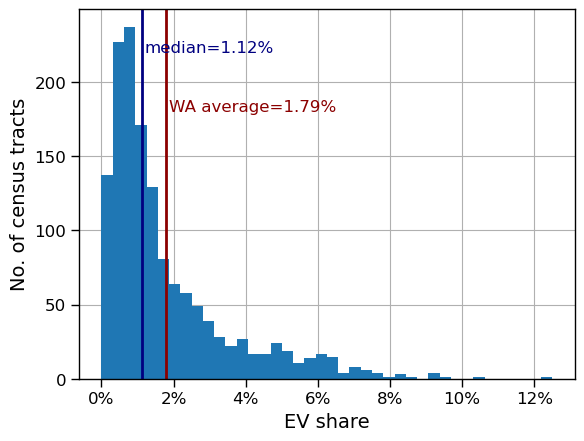

In [145]:
#histogram of p_ev in census tracts
fig,ax = plt.subplots()
ax.hist(df_today["p_ev"]*100, bins=40)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
WA_avg = df_today["n_ev"].sum()/df_today["n_veh"].sum()*100
ax.axvline(WA_avg, color="darkred", lw=2, zorder=2)
ax.text(WA_avg*1.05, 200*0.9, "WA average=%.2f%%"%WA_avg, color="darkred")
median = df_today["p_ev"].median()*100
ax.axvline(median, color="navy", lw=2, zorder=2)
ax.text(median*1.07, 200*1.1, "median=%.2f%%"%median, color="navy", zorder=3)

u.fig_ax_setup(fig, xlabel="EV share", ylabel="No. of census tracts")
u.save_figure(fig, "plots/p_ev_hist.png", dpi=200)

In [151]:
#p_ev quantile distribution
qs = np.arange(0,1.01,0.1)
quantiles = []
for q in qs:
    # print(q)
    # quantiles += [np.round(df_today["p_ev"].quantile(q),4)*100]
    quantiles += [df_today["n_ev"].quantile(q)]
quantiles

[0.0,
 10.0,
 17.0,
 26.0,
 35.0,
 47.0,
 62.0,
 83.19999999999993,
 115.0,
 174.0,
 722.0]

In [210]:
colors_dict = { "King": (0.122, 0.467, 0.706, 1.   ),
                "San Juan": (1.,    0.498, 0.055, 1.   ),
                "Jefferson": (0.839, 0.153, 0.157, 1.   ),
                "Snohomish": (0.549, 0.337, 0.294, 1.   ),
                "Kitsap": (0.89,  0.467, 0.761, 1.   ),
                "Clark": (0.737, 0.741, 0.133, 1.   ),
                "Island": (0.09,  0.745, 0.812, 1.   ),
                "Thurston": (0.173, 0.627, 0.173, 1.   ),
                }

In [242]:
#EV share by county visualizations
N = 50 #choose the N counties with highest EV share (set to a value > 39 to see all counties)
N_colored = 8
df_today_by_county = df_today.groupby("county").sum()[["n_ev", "n_bev", "n_phev", "n_veh", "n_evse", "n_total_pop", "n_white", "n_bachelor", "n_workers_16plus", "n_drove_alone", "n_units_tot", "n_units_1detached", "n_units_1attached"]]
df_today_by_county["p_ev"] = df_today_by_county["n_ev"] / df_today_by_county["n_veh"]
df_today_by_county = df_today_by_county.sort_values(by="p_ev", ascending=False)
df_today_by_county = df_today_by_county.iloc[:N]
df_today_by_county

x = df_today_by_county.index
y = df_today_by_county["p_ev"]
w = df_today_by_county["n_ev"]
# w = df_today_by_county["n_veh"]
colors = plt.get_cmap("tab10", lut=N_colored)
# Set1
# tab10

# fig,ax = plt.subplots()
# ax.bar(x, y)

42


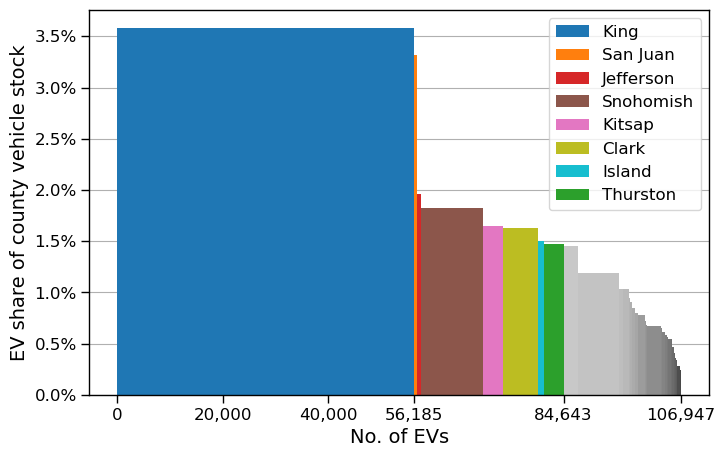

In [243]:
fig,ax = plt.subplots(figsize=(8,5))

# colors_custom = ["#732dda", "#7d4ec2", "#866ea9", "#908f91", "#99b078", "#a3d060", "#acf147"]
colors_custom = [colors(i) for i in range(N_colored)]
colors_custom = [colors_dict[county] for county in x[:N_colored]]
# print(np.array([np.array(np.round(c,3)) for c in colors_custom]))
colors_custom += get_grayscale(N-N_colored, brightest=200, darkling=True)

xticks = []
for n, c in enumerate(w):
    xticks.append(sum(w[:n]) + w[n]/2)

w_new = [i/max(w) for i in w]
a = ax.bar(xticks, height = 100*y, width = w, color = colors_custom)
# _ = plt.xticks(xticks, x)
ax.set_xticks([0, 20000, 40000, w[0], np.cumsum(w[:N_colored])[-1], np.cumsum(w)[-1]]) #for 09/2022
# ax.set_xticks([0, 2000, 4000, 6000, w[0], np.cumsum(w[:N_colored])[-1], np.cumsum(w)[-1]]) #for 12/2015

# plt.legend(a.patches, x)
ax.legend(a.patches[:N_colored], x[:N_colored])

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

u.fig_ax_setup(fig, xlabel="No. of EVs", ylabel="EV share of county vehicle stock")
# u.fig_ax_setup(fig, xlabel="No. of light-duty vehicles", ylabel="EV share of county vehicle stock")
ax.grid(axis="x")
# print(ax.get_xlim(), ax.get_ylim())
# ax.set_xlim((-5347.351, 112294.37099999998))
# ax.set_ylim((0.0, 3.757571607824154))
u.save_figure(fig, "plots/p_ev_by_county_2022_n_ev.png", dpi=200)
# u.save_figure(fig, "plots/p_ev_by_county_2022_n_veh.png", dpi=200)
# u.save_figure(fig, "plots/p_ev_by_county_2015_n_ev.png", dpi=200)
# u.save_figure(fig, "plots/p_ev_by_county_2015_n_veh.png", dpi=200)
# u.save_figure(fig, "plots/p_ev_by_county_2015_xylims.png", dpi=200)

In [68]:
#makes and models of current EV population
df_pop = pd.read_csv("data/vehicles/Electric_Vehicle_Population_Data.csv")
df_pop

,vin_1_10,county,city,state,zip_code,model_year,make,model,ev_type,cafv_type,electric_range,base_msrp,legislative_district,dol_vehicle_id,geocoded_column,electric_utility,_2020_census_tract
0,1N4BZ0CP9G,Snohomish,Arlington,WA,98223,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,39.0,238236288,NaN,PUGET SOUND ENERGY INC,53061052701
1,1N4AZ0CP5G,King,Seattle,WA,98118,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,37.0,182735367,NaN,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033011102
2,1N4BZ1CP7K,Thurston,Olympia,WA,98502,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,0,22.0,142814556,POINT (-102.71236 22.94812),NaN,53067012002
3,5YJ3E1EBXK,Frederick,Frederick,MD,21704,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,114252337,POINT (-77.368491 39.354463),NaN,24021752205
4,5YJ3E1EAXL,King,Bellevue,WA,98008,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,0,48.0,2075510,NaN,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033023100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109022,1FTFW1ED1M,King,Black Diamond,WA,98010,2021,FORD,F-150,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,5.0,179256115,POINT (-122.00143 47.30893),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033031603
109023,1G1FX6S07H,King,Seattle,WA,98106,2017,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,34.0,125716006,POINT (-122.35186 47.54286),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033010800
109024,1G1RB6S55H,King,Burien,WA,98166,2017,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53,0,34.0,226079178,POINT (-122.349394 47.45507),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033027901
109025,1G1FY6S01L,Chelan,Wenatchee,WA,98801,2020,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,259,0,12.0,144926463,POINT (-120.336499 47.425146),PUD NO 1 OF CHELAN COUNTY,53007961001


In [69]:
df_pop["ev_type"].value_counts()

Battery Electric Vehicle (BEV)            81704
Plug-in Hybrid Electric Vehicle (PHEV)    27323
Name: ev_type, dtype: int64

In [70]:
df_pop["ev_type"] = df_pop["ev_type"].map({"Battery Electric Vehicle (BEV)": "bev", "Plug-in Hybrid Electric Vehicle (PHEV)": "phev"})

In [71]:
df_pop["make_model"] = df_pop["make"] + " " + df_pop["model"]
model_counts_bev = df_pop.loc[df_pop["ev_type"]=="bev", "make_model"].value_counts()
model_counts_phev = df_pop.loc[df_pop["ev_type"]=="phev", "make_model"].value_counts()
model_counts_bev

TESLA MODEL 3                              21715
TESLA MODEL Y                              14468
NISSAN LEAF                                12916
TESLA MODEL S                               7198
CHEVROLET BOLT EV                           4675
TESLA MODEL X                               3945
KIA NIRO                                    2570
FORD MUSTANG MACH-E                         1467
VOLKSWAGEN ID.4                             1249
FORD F-150                                  1053
VOLKSWAGEN E-GOLF                           1048
KIA EV6                                      939
FIAT 500                                     822
AUDI E-TRON                                  781
BMW I3                                       587
POLESTAR PS2                                 500
VOLVO XC40                                   485
RIVIAN R1T                                   481
KIA SOUL                                     440
MINI HARDTOP                                 405
PORSCHE TAYCAN      

In [72]:
# model_counts_bev.to_csv("results/model_counts_bev.csv")
# model_counts_phev.to_csv("results/model_counts_phev.csv")

In [88]:
def find_best_matching_model(fuzzy_model, ev_type, return_score=False):
    if fuzzy_model is None:
        return None
    if ev_type == "bev":
        try:
            highest = process.extractOne(fuzzy_model, make_models_bev)
        except TypeError:
            highest = (None, -1)
    elif ev_type == "phev":
        try:
            highest = process.extractOne(fuzzy_model, make_models_phev)
        except TypeError:
            highest = (None, -1)
    # print("highest", " ", end="")
    # return highest
    if return_score:
        return highest[1]
    else:
        if highest[1] > 89:
            return highest[0]
        else:
            return None

In [89]:
find_best_matching_model("AUDI Q5 E", "phev")
find_best_matching_model("VOLVO XC60", "phev")
find_best_matching_model("FORD FUSION", "phev")
print(find_best_matching_model(None, "phev"))
# find_best_matching_model("VOLVO 60", "phev")
# find_best_matching_model("TOYOTA PRIUS PLUG-IN", "phev")
# find_best_matching_model("TOYOTA PRIUS PRIME", "phev")
# find_best_matching_model("TOYOTA PRIUS PLUG-IN HYBRID", "phev")

None


In [75]:
# df_pop = df_pop.iloc[:1000]

In [90]:
start = time.time()
df_pop["make_model_bev"] = df_pop["make_model"].apply(find_best_matching_model, ev_type="bev")
print("hello")
# df_pop["make_model_bev_score"] = df_pop["make_model"].apply(find_best_matching_model, ev_type="bev", return_score=True)
df_pop["make_model_phev"] = df_pop["make_model"].apply(find_best_matching_model, ev_type="phev")
# df_pop["make_model_phev_score"] = df_pop["make_model"].apply(find_best_matching_model, ev_type="phev", return_score=True)
df_pop.loc[df_pop["ev_type"] == "bev", "make_model_phev"] = None
df_pop.loc[df_pop["ev_type"] == "phev", "make_model_bev"] = None
end = time.time()
print(end-start)

hello
1979.5682985782623


In [61]:
# df_pop["make_model_bev_score"].hist(bins=100)

In [92]:
# df_pop[["ev_type", "make_model", "make_model_bev", "make_model_bev_score", "make_model_phev", "make_model_phev_score"]]
df_pop[["ev_type", "make_model", "make_model_bev", "make_model_phev"]]

,ev_type,make_model,make_model_bev,make_model_phev
0,bev,NISSAN LEAF,Nissan Leaf,None
1,bev,NISSAN LEAF,Nissan Leaf,None
2,bev,NISSAN LEAF,Nissan Leaf,None
3,bev,TESLA MODEL 3,Tesla Model 3,None
4,bev,TESLA MODEL 3,Tesla Model 3,None
...,...,...,...,...
109022,bev,FORD F-150,Ford F-150 Lightning,None
109023,bev,CHEVROLET BOLT EV,Chevrolet Bolt EV,None
109024,phev,CHEVROLET VOLT,None,Chevrolet Volt
109025,bev,CHEVROLET BOLT EV,Chevrolet Bolt EV,None


In [ ]:
df_pop.to_csv("data/vehicles/df_pop_make_model.csv")

In [ ]:
#started at 5:43pm

In [28]:
df_pop = pd.read_csv("data/vehicles/df_pop_make_model.csv")
df_pop = df_pop.drop("Unnamed: 0", axis=1)
df_pop

,vin_1_10,county,city,state,zip_code,model_year,make,model,ev_type,cafv_type,electric_range,base_msrp,legislative_district,dol_vehicle_id,geocoded_column,electric_utility,_2020_census_tract,make_model,make_model_bev,make_model_phev
0,1N4BZ0CP9G,Snohomish,Arlington,WA,98223,2016,NISSAN,LEAF,bev,Clean Alternative Fuel Vehicle Eligible,84,0,39.0,238236288,NaN,PUGET SOUND ENERGY INC,53061052701,NISSAN LEAF,Nissan Leaf,NaN
1,1N4AZ0CP5G,King,Seattle,WA,98118,2016,NISSAN,LEAF,bev,Clean Alternative Fuel Vehicle Eligible,84,0,37.0,182735367,NaN,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033011102,NISSAN LEAF,Nissan Leaf,NaN
2,1N4BZ1CP7K,Thurston,Olympia,WA,98502,2019,NISSAN,LEAF,bev,Clean Alternative Fuel Vehicle Eligible,150,0,22.0,142814556,POINT (-102.71236 22.94812),NaN,53067012002,NISSAN LEAF,Nissan Leaf,NaN
3,5YJ3E1EBXK,Frederick,Frederick,MD,21704,2019,TESLA,MODEL 3,bev,Clean Alternative Fuel Vehicle Eligible,220,0,NaN,114252337,POINT (-77.368491 39.354463),NaN,24021752205,TESLA MODEL 3,Tesla Model 3,NaN
4,5YJ3E1EAXL,King,Bellevue,WA,98008,2020,TESLA,MODEL 3,bev,Clean Alternative Fuel Vehicle Eligible,266,0,48.0,2075510,NaN,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033023100,TESLA MODEL 3,Tesla Model 3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109022,1FTFW1ED1M,King,Black Diamond,WA,98010,2021,FORD,F-150,bev,Eligibility unknown as battery range has not b...,0,0,5.0,179256115,POINT (-122.00143 47.30893),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033031603,FORD F-150,Ford F-150 Lightning,NaN
109023,1G1FX6S07H,King,Seattle,WA,98106,2017,CHEVROLET,BOLT EV,bev,Clean Alternative Fuel Vehicle Eligible,238,0,34.0,125716006,POINT (-122.35186 47.54286),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033010800,CHEVROLET BOLT EV,Chevrolet Bolt EV,NaN
109024,1G1RB6S55H,King,Burien,WA,98166,2017,CHEVROLET,VOLT,phev,Clean Alternative Fuel Vehicle Eligible,53,0,34.0,226079178,POINT (-122.349394 47.45507),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033027901,CHEVROLET VOLT,NaN,Chevrolet Volt
109025,1G1FY6S01L,Chelan,Wenatchee,WA,98801,2020,CHEVROLET,BOLT EV,bev,Clean Alternative Fuel Vehicle Eligible,259,0,12.0,144926463,POINT (-120.336499 47.425146),PUD NO 1 OF CHELAN COUNTY,53007961001,CHEVROLET BOLT EV,Chevrolet Bolt EV,NaN


In [76]:
bev_models_to_drop = ["Volkswagen e-Golf", "Audi e-tron", "Kia EV6", "Fiat 500e"]
phev_models_to_drop = []
df_pop.loc[df_pop["make_model_bev"].isin(bev_models_to_drop), "make_model_bev"] = None
df_pop.loc[df_pop["make_model_phev"].isin(phev_models_to_drop), "make_model_phev"] = None
N_bev,N_phev = df_pop["ev_type"].value_counts()
counts_bev = pd.DataFrame({"count_bev": df_pop.loc[df_pop["ev_type"]=="bev", "make_model_bev"].value_counts(dropna=False)})
counts_bev["pct"] = np.round(counts_bev["count_bev"]/N_bev*100,3)#.astype(str) + "%"
counts_phev = pd.DataFrame({"count_phev": df_pop.loc[df_pop["ev_type"]=="phev", "make_model_phev"].value_counts(dropna=False)})
counts_phev["pct"] = np.round(counts_phev["count_phev"]/N_phev*100,1)#.astype(str) + "%"
print(N_bev,N_phev,N_bev+N_phev)

81704 27323 109027


In [77]:
#save model counts
# counts_bev.to_csv("results/stats/model_counts_bev.csv")
# counts_phev.to_csv("results/stats/model_counts_phev.csv")

In [78]:
counts_bev = counts_bev.rename(index={np.nan: "Other models"})
counts_phev = counts_phev.rename(index={np.nan: "Other models"})
#move other models to end
idx_bev = counts_bev.index.tolist()
idx_bev.remove("Other models")
idx_phev = counts_phev.index.tolist()
idx_phev.remove("Other models")
counts_bev = counts_bev.reindex(idx_bev + ["Other models"])
counts_phev = counts_phev.reindex(idx_phev + ["Other models"])
counts_phev

,count_phev,pct
Chevrolet Volt,4938,18.1
Toyota Prius,3289,12.0
Ford Fusion PHEV,1856,6.8
Chrysler Pacifica PHEV,1764,6.5
Ford C-Max PHEV,1577,5.8
BMW X5 PHEV,1421,5.2
BMW i3,1324,4.8
Jeep Wrangler PHEV,1059,3.9
Volvo XC90 PHEV,1006,3.7
Toyota RAV4 Prime,963,3.5


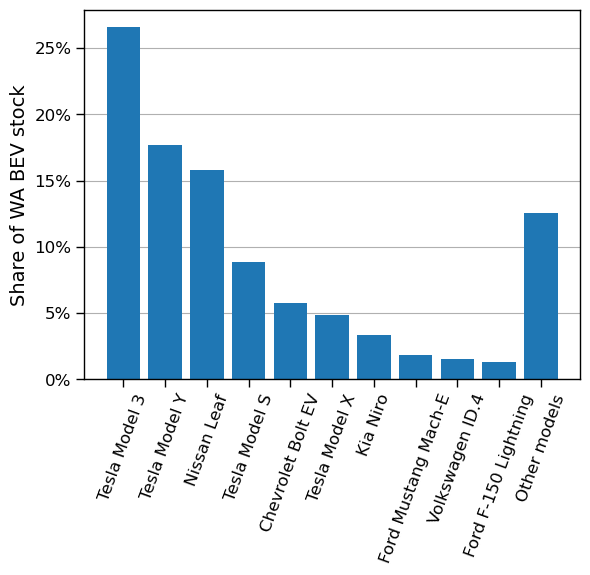

In [84]:
fig,ax = plt.subplots()

ev_type = "BEV"
# ev_type = "PHEV"

if ev_type == "BEV":
    x = counts_bev.index
    y = counts_bev["count_bev"]
    y = counts_bev["pct"]
elif ev_type == "PHEV":
    x = counts_phev.index
    y = counts_phev["count_phev"]
    y = counts_phev["pct"]

ax.bar(x, y)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

u.fig_ax_setup(fig, ylabel="Share of WA %s stock"%ev_type, xtick_rotation=70)
# u.fig_ax_setup(fig, xlabel="No. of light-duty vehicles", ylabel="EV share of county vehicle stock")
ax.grid(axis="x")
u.save_figure(fig, "plots/models_%s.png"%ev_type, dpi=200)


In [7]:
#investigate vehicle counts
number = 3
df_fileX = pd.read_csv("data/vehicles/veh_counts_file%d.csv"%number)
df_fileX = df_fileX.convert_dtypes()
df_fileX["time"] = pd.to_datetime(df_fileX["time"]).dt.date

# df_fileX = df_fileX.set_index(["time", "census_tract_2010"])
# df_fileX.index.dtypes[1] = "int64"
df_fileX

,time,census_tract,county,zip_code,n_veh,n_veh_new_sales
0,2015-01-31,53001950100,Adams,99169,0,0
1,2015-01-31,53001950200,Adams,99371,0,0
2,2015-01-31,53001950301,<NA>,<NA>,0,0
3,2015-01-31,53001950302,<NA>,<NA>,0,0
4,2015-01-31,53001950303,<NA>,<NA>,0,0
...,...,...,...,...,...,...
165907,2022-09-30,53077940003,Yakima,98903,0,0
165908,2022-09-30,53077940005,Yakima,98948,0,0
165909,2022-09-30,53077940006,Yakima,98948,0,0
165910,2022-09-30,53077940007,<NA>,<NA>,0,0
